In [3]:
# Installs
import sys
!echo "Purging pip environment and installing packages..."
!{sys.executable} -m pip cache purge 
!{sys.executable} -m pip uninstall -y jlu 
!{sys.executable} -m pip install -q git+https://github.com/arvest-data-in-context/jlu 
!{sys.executable} -m pip uninstall -y dps
!{sys.executable} -m pip install -q git+https://github.com/jdchart/dps.git

# Imports
print("Importing packages...")
import os
import jlu
import dps
import matplotlib.pyplot as plt
import numpy as np
print("Ready!")

"Purging pip environment and installing packages..."
Files removed: 0


Found existing installation: jlu 0.0.1
Uninstalling jlu-0.0.1:
  Successfully uninstalled jlu-0.0.1
Found existing installation: dps 0.0.1
Uninstalling dps-0.0.1:
  Successfully uninstalled dps-0.0.1
Importing packages...
Ready!


In [4]:
VOSK_ANALYSES = r"C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\input"
analysis_files = jlu.files.collect_files(VOSK_ANALYSES, ["json"])
print(analysis_files)

['C:\\Users\\theoh\\Documents\\Fac\\Thèse\\Donnees\\DPS_LMI\\Fusion\\input\\LMI_20220826_1_0.0_8753.398625_mergedlength.json', 'C:\\Users\\theoh\\Documents\\Fac\\Thèse\\Donnees\\DPS_LMI\\Fusion\\input\\LMI_20220828_1_0.0_8755.0443125_mergedlength.json', 'C:\\Users\\theoh\\Documents\\Fac\\Thèse\\Donnees\\DPS_LMI\\Fusion\\input\\LMI_20230427_0_9774.48_final_mergedlength.json', 'C:\\Users\\theoh\\Documents\\Fac\\Thèse\\Donnees\\DPS_LMI\\Fusion\\input\\LMI_20230428_0_9152.85_final_mergedlength.json', 'C:\\Users\\theoh\\Documents\\Fac\\Thèse\\Donnees\\DPS_LMI\\Fusion\\input\\LMI_20230502_0_9443.910015000003_final_mergedlength.json', 'C:\\Users\\theoh\\Documents\\Fac\\Thèse\\Donnees\\DPS_LMI\\Fusion\\input\\LMI_20230503_0_9331.260030000001_final_mergedlength.json', 'C:\\Users\\theoh\\Documents\\Fac\\Thèse\\Donnees\\DPS_LMI\\Fusion\\input\\LMI_20230504_0_9333.569985_final_mergedlength.json', 'C:\\Users\\theoh\\Documents\\Fac\\Thèse\\Donnees\\DPS_LMI\\Fusion\\input\\LMI_20230505_0_9338.91_fina

In [5]:
import json
import numpy as np
import os

# Paramètres
WINDOW_SEC = 1     # Durée de la fenêtre en secondes
HOP_SEC = 0.5      # Pas de la fenêtre
fps = 32           # Frame rate utilisé pour conversion en temps

# Résultat : dictionnaire {nom_fichier: courbe_wps}
wps_curves_complete = {}

for file_path in analysis_files:
    file_name = os.path.basename(file_path)

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    words = [w for w in data["result"] if "start" in w and "end" in w]
    if not words:
        print(f"⚠️ Aucun mot détecté dans {file_name}")
        continue

    # Création du tableau de timestamps
    start_times = np.array([w["start"] for w in words])
    end_times = np.array([w["end"] for w in words])

    # Durée totale
    total_duration = max(end_times)

    # Fenêtrage
    window_size = WINDOW_SEC
    hop_size = HOP_SEC
    times = np.arange(0, total_duration, hop_size)

    wps_values = []

    for t in times:
        in_window = (start_times >= t - window_size / 2) & (end_times <= t + window_size / 2)
        word_count = np.sum(in_window)
        wps = word_count / window_size
        wps_values.append(wps)

    wps_curves_complete[file_name] = np.array(wps_values)

print(f"✅ Courbes WPS recalculées pour {len(wps_curves_complete)} fichiers")
print (wps_curves_complete["LMI_20220826_1_0.0_8753.398625_mergedlength.json"].shape)


✅ Courbes WPS recalculées pour 13 fichiers
(17459,)


In [4]:
import pandas as pd

N_WINDOWS = 200
fps = 32
bins = [0, 1, 2, 3, 5]
bin_labels = ["[0–1[", "[1–2[", "[2–3[", "[3–5]"]

window_stats = []

for file_name, curve in wps_curves_complete.items():  # CHANGEMENT ICI
    data = np.array(curve, dtype=np.float64)
    data = np.nan_to_num(data, nan=0.0)

    total_len = len(data)
    points_per_window = total_len // N_WINDOWS

    for w in range(N_WINDOWS):
        start = w * points_per_window
        end = (w + 1) * points_per_window if w < N_WINDOWS - 1 else total_len
        segment = data[start:end]
        segment_nonzero = segment[segment > 0]

        # Temps de début et de fin (en secondes)
        start_time = start / fps
        end_time = end / fps

        # Statistiques de base
        stats = {
            "file": file_name,
            "window": w,
            "start_time_s": round(start_time, 2),
            "end_time_s": round(end_time, 2),
            "start_time_mn": f"{int(start_time // 60):02}:{int(start_time % 60):02}",
            "end_time_mn": f"{int(end_time // 60):02}:{int(end_time % 60):02}",
            "count_words": len(segment_nonzero),
            "mean": np.mean(segment_nonzero) if len(segment_nonzero) > 0 else 0,
            "std": np.std(segment_nonzero) if len(segment_nonzero) > 0 else 0,
            "min": np.min(segment_nonzero) if len(segment_nonzero) > 0 else 0,
            "max": np.max(segment_nonzero) if len(segment_nonzero) > 0 else 0
        }

        # Répartition par bins
        bin_counts, _ = np.histogram(segment_nonzero, bins=bins)
        for label, count in zip(bin_labels, bin_counts):
            stats[f"count {label}"] = count
            stats[f"perc {label}"] = (count / len(segment_nonzero) * 100) if len(segment_nonzero) > 0 else 0

        window_stats.append(stats)

# Création du DataFrame final
df_windows = pd.DataFrame(window_stats).round(2)
display(df_windows.head())


,file,window,start_time_s,end_time_s,start_time_mn,end_time_mn,count_words,mean,std,min,max,count [0–1[,perc [0–1[,count [1–2[,perc [1–2[,count [2–3[,perc [2–3[,count [3–5],perc [3–5]
0,LMI_20220826_1_0.0_8753.398625_mergedlength.json,0,0.00,2.72,00:00,00:02,5,1.00,0.00,1.0,1.0,0,0.0,5,100.00,0,0.00,0,0.00
1,LMI_20220826_1_0.0_8753.398625_mergedlength.json,1,2.72,5.44,00:02,00:05,0,0.00,0.00,0.0,0.0,0,0.0,0,0.00,0,0.00,0,0.00
2,LMI_20220826_1_0.0_8753.398625_mergedlength.json,2,5.44,8.16,00:05,00:08,10,2.20,0.75,1.0,3.0,0,0.0,2,20.00,4,40.00,4,40.00
3,LMI_20220826_1_0.0_8753.398625_mergedlength.json,3,8.16,10.88,00:08,00:10,24,1.25,0.52,1.0,3.0,0,0.0,19,79.17,4,16.67,1,4.17
4,LMI_20220826_1_0.0_8753.398625_mergedlength.json,4,10.88,13.59,00:10,00:13,34,1.29,0.52,1.0,3.0,0,0.0,25,73.53,8,23.53,1,2.94


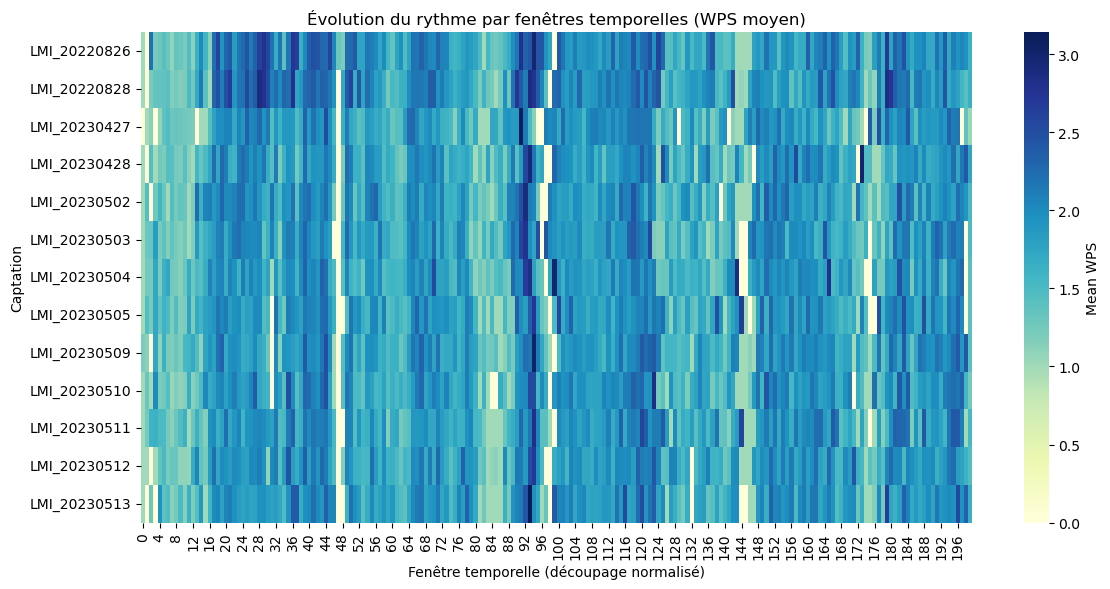

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Réduction du nom des fichiers à 12 caractères
heatmap_matrix = df_windows.pivot(index="file", columns="window", values="mean")
heatmap_matrix.index = [f[:12] for f in heatmap_matrix.index]

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_matrix, annot=False, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean WPS'})
plt.title("Évolution du rythme par fenêtres temporelles (WPS moyen)")
plt.xlabel("Fenêtre temporelle (découpage normalisé)")
plt.ylabel("Captation")
plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import pandas as pd

# Recharger le CSV du chronométrage manuel
stopwatch_csv_path = r"C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\operate1curve\LMI_Stopwatch_20230509.csv"
df_stopwatch = pd.read_csv(stopwatch_csv_path, decimal=',')


# Définir la durée cible du filage (en secondes)
total_duration = df_stopwatch['end_time_s'].max()

# Créer un signal "continu" à la seconde près (rempli de NaN par défaut)
wps_signal = np.full(int(np.ceil(total_duration)), np.nan)

# Remplir les valeurs du signal selon chaque séquence
for _, row in df_stopwatch.iterrows():
    start = int(np.floor(row['start_time_s']))
    end = int(np.ceil(row['end_time_s']))
    wps_signal[start:end] = row['wps_mean']

# Nombre de fenêtres (doit matcher df_windows pour heatmap)
N_WINDOWS = 200
samples_per_window = len(wps_signal) // N_WINDOWS

manual_window_stats = []

for i in range(N_WINDOWS):
    start = i * samples_per_window
    end = (i + 1) * samples_per_window if i < N_WINDOWS - 1 else len(wps_signal)
    segment = wps_signal[start:end]
    segment_non_nan = segment[~np.isnan(segment)]
    
    mean_wps = np.mean(segment_non_nan) if len(segment_non_nan) > 0 else np.nan

    manual_window_stats.append({
        'file': 'Manual_Stopwatch',
        'window': i,
        'mean': round(mean_wps, 2)
    })

# Convertir en DataFrame
df_manual_windows = pd.DataFrame(manual_window_stats)


In [7]:
df_combined = pd.concat([df_windows[['file', 'window', 'mean']], df_manual_windows], ignore_index=True)


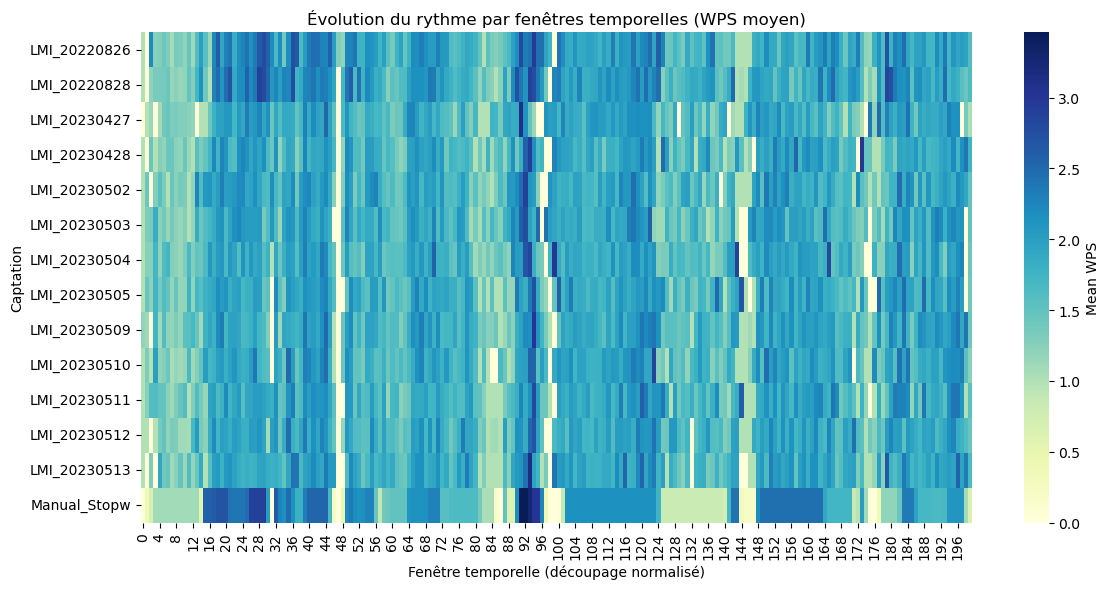

In [8]:
heatmap_matrix = df_combined.pivot(index="file", columns="window", values="mean")
heatmap_matrix.index = [f[:12] for f in heatmap_matrix.index]

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_matrix, annot=False, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean WPS'})
plt.title("Évolution du rythme par fenêtres temporelles (WPS moyen)")
plt.xlabel("Fenêtre temporelle (découpage normalisé)")
plt.ylabel("Captation")
plt.tight_layout()
plt.show()


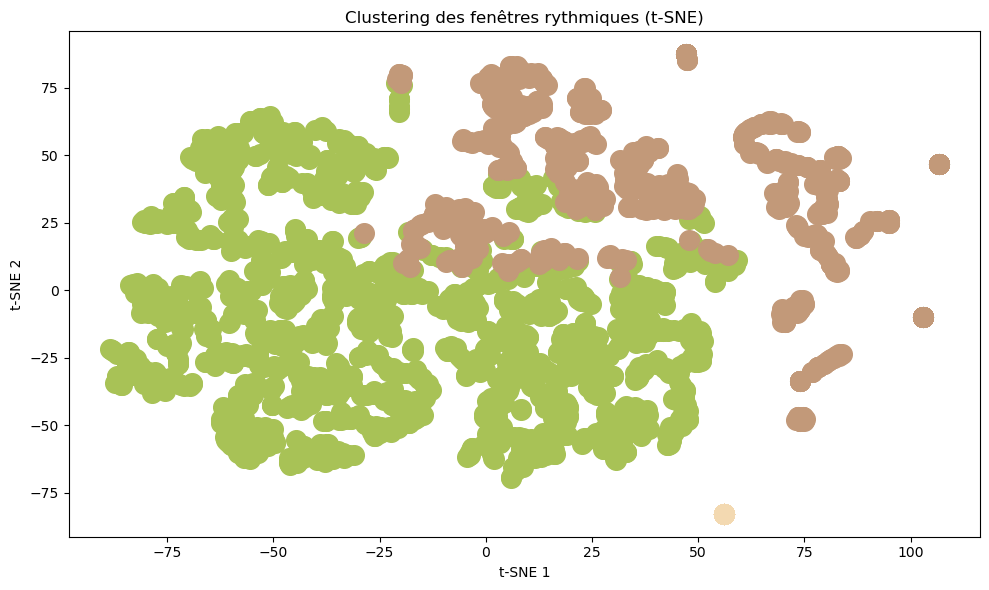

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

#couleurs
cluster_colors_hex = [
        "#A8C256", #vert jaune
        "#F3D9B1", #beige
        "#C29979", #marron
        "#C33149", #rouge carmin
        "#008744", #vert
        "#FF715B", # rouge doux
        "#2F52E0", #bleu
        "#F9CB40", #orange doux
        "#ff3c26", #orange foncé 
        "#BCED09", #vert citron
        "#0057e7",
        "#d62d20",
        "#ffa700",
        "#ff8640", #orange
        "#ff3c26", #orange foncé 
        "#362559", #violet
        "#ffc578"
]


# Sélection des colonnes numériques
features = ['mean', 'std', 'min', 'max', 'count_words'] + [col for col in df_windows.columns if col.startswith("perc")]
X = df_windows[features].fillna(0)

# Standardisation
X_scaled = StandardScaler().fit_transform(X)

# Clustering
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_scaled)
df_windows["cluster"] = labels


# Réduction dimensionnelle
X_tsne = TSNE(n_components=2, perplexity=10, random_state=0).fit_transform(X_scaled)

# Affichage t-SNE
plt.figure(figsize=(10, 6))
for cluster_id in range(10):
    idx = labels == cluster_id
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                color=cluster_colors_hex[cluster_id],
                label=f"Cluster {cluster_id}", s=200)

# Légende : fichier + fenêtre
#for i, row in df_windows.iterrows():
    #label = f"{row['file'][:10]}-{int(row['window'])}"
    #plt.annotate(label, (X_tsne[i, 0], X_tsne[i, 1]), fontsize=3, alpha=0.7)

plt.title("Clustering des fenêtres rythmiques (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


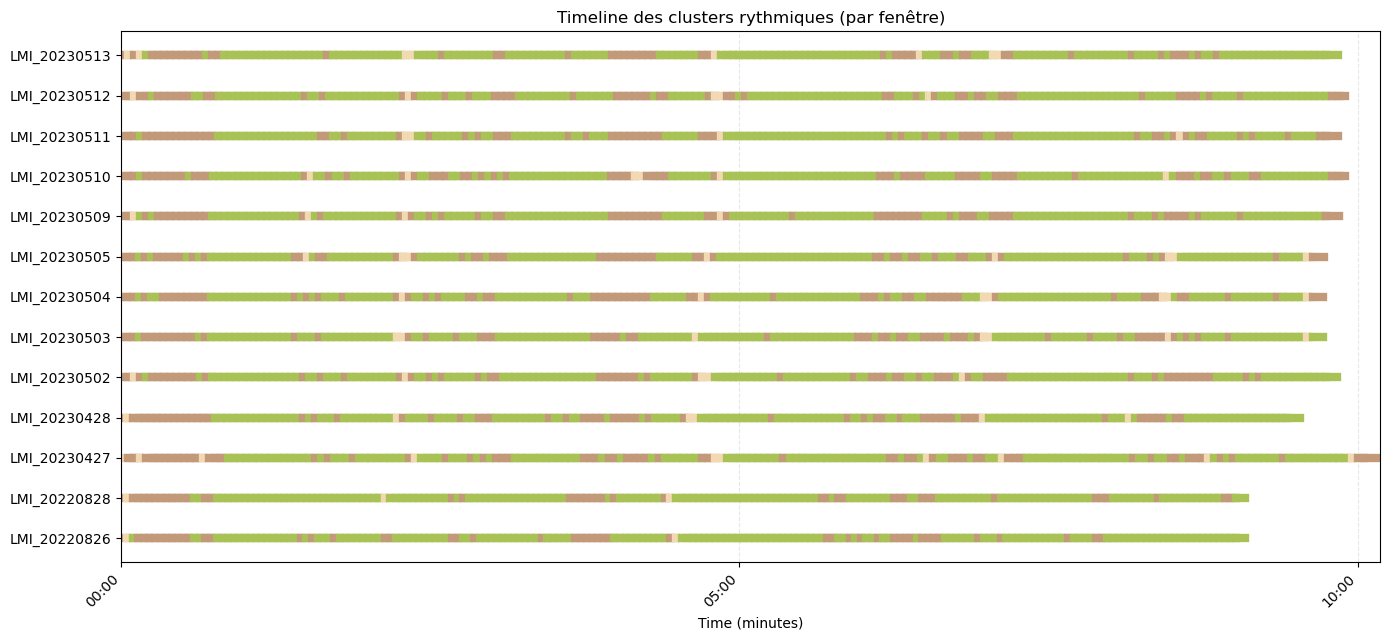

In [15]:
import matplotlib.pyplot as plt
import numpy as np

df_windows["cluster"] = labels
ordered_files = list(wps_curves_complete.keys())

plt.figure(figsize=(14, len(ordered_files) * 0.5))

for i, file in enumerate(ordered_files):
    file_windows = df_windows[df_windows["file"] == file]
    for _, row in file_windows.iterrows():
        try:
            color = cluster_colors_hex[int(row["cluster"])]
            #print ([row["start_time_s"] / 60, row["end_time_s"] / 60])
            plt.plot([row["start_time_s"] / 60, row["end_time_s"] / 60], [i, i],
                     color=color, linewidth=6)
        except (KeyError, IndexError):
            continue

# 🔧 Calcule la durée max AVANT de définir les xticks
max_duration_s = df_windows["end_time_s"].max()
max_duration_min = max_duration_s / 60

# 🎯 Axe X formaté correctement
def format_time(seconds):
    minutes = int(seconds // 60)
    seconds = int(seconds % 60)
    return f"{minutes:02}:{seconds:02}"

xticks = np.arange(0, int(max_duration_min) + 1, 5)
xtick_labels = [format_time(t * 60) for t in xticks]
plt.xticks(ticks=xticks, labels=xtick_labels, rotation=45, ha='right')

plt.xlim(0, max_duration_min)

# 🎯 Axe Y
plt.yticks(range(len(ordered_files)), [f[:12] for f in ordered_files])
plt.xlabel("Time (minutes)")
plt.title("Timeline des clusters rythmiques (fenêtres sur courbes complètes)")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#print (ordered_files)

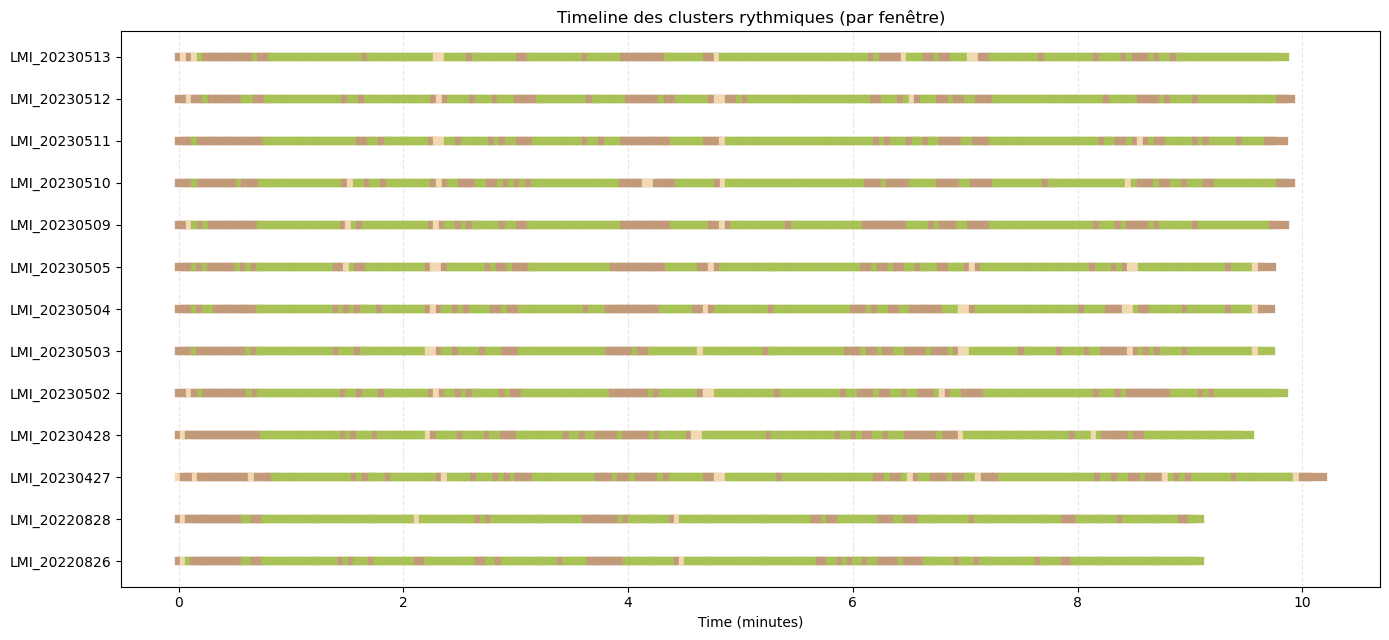

In [18]:
import matplotlib.pyplot as plt

# Ordre des fichiers d'origine
ordered_files = list(wps_curves_complete.keys())

plt.figure(figsize=(14, len(ordered_files) * 0.5))

for i, file in enumerate(ordered_files):
    file_windows = df_windows[df_windows["file"] == file]
    for _, row in file_windows.iterrows():
        color = cluster_colors_hex[int(row["cluster"])]
        plt.plot([row["start_time_s"] / 60, row["end_time_s"] / 60],
                 [i, i], color=color, linewidth=6)

# Annotations éventuelles
if 'df_event_windows' in locals():
    for _, row in df_event_windows.iterrows():
        try:
            y_index = ordered_files.index(row["file"])
            x_pos = (row["start_time_s"] + row["end_time_s"]) / 2 / 60
            plt.text(x_pos, y_index + 0.3, row["event_label"],
                     fontsize=8, ha="center", va="bottom", color="black")
        except ValueError:
            continue

plt.yticks(range(len(ordered_files)), [f[:12] for f in ordered_files])
plt.xlabel("Time (minutes)")
plt.title("Timeline des clusters rythmiques (par fenêtre)")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
